In [332]:
import os
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score

<b> Data Acqusition </b>

In [275]:
users_df = pd.read_csv("takehome_users.csv", parse_dates=['creation_time'], encoding="ISO-8859-1")

In [276]:
engagement_df = pd.read_csv("takehome_user_engagement.csv", parse_dates=['time_stamp'])

In [277]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [278]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [279]:
users_df.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [280]:
users_df.index

RangeIndex(start=0, stop=12000, step=1)

In [281]:
engagement_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


There are no null values present in the engagement datafile. 

In [282]:
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [283]:
engagement_df.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


<b> Data wrangling </b>


In [284]:
#convert 'last_session_creation_time' to datetime
users_df['last_session_creation_time'] = pd.to_datetime(users_df.last_session_creation_time, unit='s')

In [285]:
users_df.opted_in_to_mailing_list = users_df.opted_in_to_mailing_list.astype('bool')
users_df.enabled_for_marketing_drip = users_df.enabled_for_marketing_drip.astype('bool')

We observe some null values in the 'last_session_creation_time' in the users table and it's in the wrong format. Let's convert it to a datetime object and handle the missing values later on. 

There are also some missing values in the 'invited_by_user_id' feature. The null values in this column indicates that the users has signed up organically. Let's reflect this: 

In [286]:
users_df['invited'] = users_df.invited_by_user_id.apply(lambda x: 0 if np.isnan(x) else 1)
users_df.invited.value_counts()

1    6417
0    5583
Name: invited, dtype: int64

In [287]:
#drop irrelevant personal info
users_df.drop(['name', 'email','invited_by_user_id'], axis=1, inplace=True)

<b> Feature Engineering </b>

We need to define the response variable, 'adopted_user', as a user who has logged into the product on three separate days in at least one seven day period. We need to only considered loggings on separate days and multiple loggings on the same day don't count.

In [288]:
# Update user_df to add response variable column 

users_df['adopted_user'] = 0 
users_df.set_index('object_id',inplace=True) 
users_df.index.name = 'user_id'
users_df.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited,adopted_user
user_id,,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,True,False,11,1,0
2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,False,False,1,1,0
3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,False,False,94,1,0
4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,False,False,1,1,0
5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,False,False,193,1,0


In [289]:
def logins_in_days(df, days=7, logins=3):
    from datetime import timedelta
    # first drop duplicate days and sort by day
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    # calculate how many days has passed for every 3 logins
    passed_days = df['date'].diff(periods=logins-1)
    # check if any passed time is less than 7 days
    return any(passed_days <= timedelta(days=days))


In [290]:
#drop multiple loggings on the same day
engagement_df['time_stamp'] = engagement_df.time_stamp.dt.date
engagement_df = engagement_df.sort_values(['user_id', 'time_stamp']).drop_duplicates()
engagement_df.head(10)


,time_stamp,user_id,visited
0,2014-04-22,1,1
1,2013-11-15,2,1
2,2013-11-29,2,1
3,2013-12-09,2,1
4,2013-12-25,2,1
5,2013-12-31,2,1
6,2014-01-08,2,1
7,2014-02-03,2,1
8,2014-02-08,2,1
9,2014-02-09,2,1


In [291]:
for idx in engagement_df.index[:-2]:
    if engagement_df.loc[idx, 'user_id'] == engagement_df.loc[idx+2, 'user_id']:
        if (engagement_df.loc[idx+2,'time_stamp'] - engagement_df.loc[idx,'time_stamp']).days <= 7:
            user_id = engagement_df.loc[idx,'user_id']
            users_df.loc[user_id, 'adopted_user'] = 1
            

In [292]:
users_df.adopted_user.value_counts()

0    10344
1     1656
Name: adopted_user, dtype: int64

We note that out of 12,000 users, only 1656 have been adopted. 

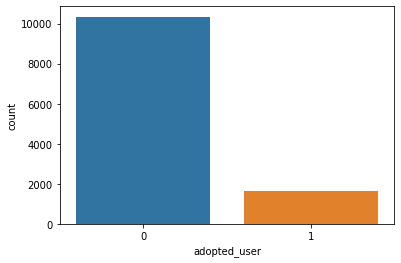

In [293]:
ax = sns.countplot(x="adopted_user", data=users_df)

We observe the response variable classes are highly imbalanced. 

Additionally we can compute for how long the user has used this product by using the 'last_session_creation_time' and 'creation_time' features.

It should be noted that there will be some missing values in the newly created 'history' feature, arising from the missing values in 'last_session_creation_time'. These missing values are probably due to user not using the prodcut at all even though an account was created. Before creating the new feature, we need to impute the missing values in 'last_session_creation_time' to be equal to 'creation_time', so that the history becomes zero. 

In [294]:
users_df['last_session_creation_time'] = users_df['last_session_creation_time'].fillna(users_df['creation_time'])

In [295]:
users_df['history'] = users_df['last_session_creation_time'] - users_df['creation_time']
users_df['history'] = users_df['history'].dt.days

In [296]:
users_df['history'].min()

0

Additionally, we can create another feature to get an idea how many times a given user had used the product.

In [297]:
total_visits = engagement_df.groupby('user_id').visited.count()
total_visits.name = 'total_visits'

In [298]:
complete_df = users_df.join(total_visits, how='left')
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   creation_source             12000 non-null  object        
 2   last_session_creation_time  12000 non-null  datetime64[ns]
 3   opted_in_to_mailing_list    12000 non-null  bool          
 4   enabled_for_marketing_drip  12000 non-null  bool          
 5   org_id                      12000 non-null  int64         
 6   invited                     12000 non-null  int64         
 7   adopted_user                12000 non-null  int64         
 8   history                     12000 non-null  int64         
 9   total_visits                8823 non-null   float64       
dtypes: bool(2), datetime64[ns](2), float64(1), int64(4), object(1)
memory usage: 1.2+ MB


In [299]:
# fill in missing data with 0 since no entry in 'engagement' dataframe means no visit
complete_df['total_visits'] = complete_df.total_visits.fillna(0).astype('int') 

In [300]:
complete_df.describe()

,org_id,invited,adopted_user,history,total_visits
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,141.884583,0.534750,0.138000,43.543083,17.326417
std,124.056723,0.498812,0.344914,126.352426,64.287839
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,0.000000,0.000000,0.000000,0.000000
50%,108.000000,1.000000,0.000000,0.000000,1.000000
75%,238.250000,1.000000,0.000000,3.000000,1.000000
max,416.000000,1.000000,1.000000,729.000000,606.000000


In [301]:
complete_df['org_id'] = complete_df.org_id.astype('object')
complete_df['invited'] = complete_df.invited.astype('object')
complete_df['adopted_user'] = complete_df.adopted_user.astype('object')

In [302]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   creation_source             12000 non-null  object        
 2   last_session_creation_time  12000 non-null  datetime64[ns]
 3   opted_in_to_mailing_list    12000 non-null  bool          
 4   enabled_for_marketing_drip  12000 non-null  bool          
 5   org_id                      12000 non-null  object        
 6   invited                     12000 non-null  object        
 7   adopted_user                12000 non-null  object        
 8   history                     12000 non-null  int64         
 9   total_visits                12000 non-null  int64         
dtypes: bool(2), datetime64[ns](2), int64(2), object(4)
memory usage: 1.2+ MB


In [303]:
complete_df.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited,adopted_user,history,total_visits
user_id,,,,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,True,False,11,1,0,0,1
2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,False,False,1,1,1,136,14
3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,False,False,94,1,0,0,1
4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,False,False,1,1,0,1,1
5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,False,False,193,1,0,5,1


<b> Exploratory Data Analysis </b>

,opted_in_to_mailing_list,enabled_for_marketing_drip,history,total_visits
opted_in_to_mailing_list,1.000000,0.483529,0.006949,0.005379
enabled_for_marketing_drip,0.483529,1.000000,0.008836,0.003932
history,0.006949,0.008836,1.000000,0.922393
total_visits,0.005379,0.003932,0.922393,1.000000


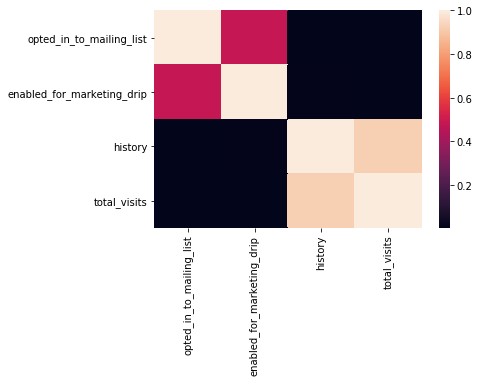

In [304]:
sns.heatmap(complete_df.corr());
complete_df.corr()

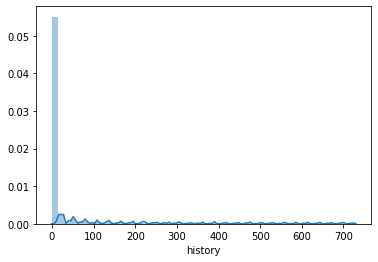

In [305]:
sns.distplot(complete_df['history'], hist=True, kde=True);

There are some users who have been using this product for over 700 days (~2 years), while the majority of the users have been using this for less than a month or so.

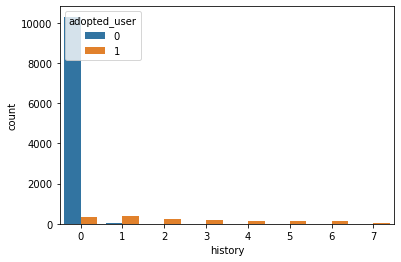

In [306]:
ax = sns.countplot(x=complete_df['history']//100, hue=complete_df.adopted_user)

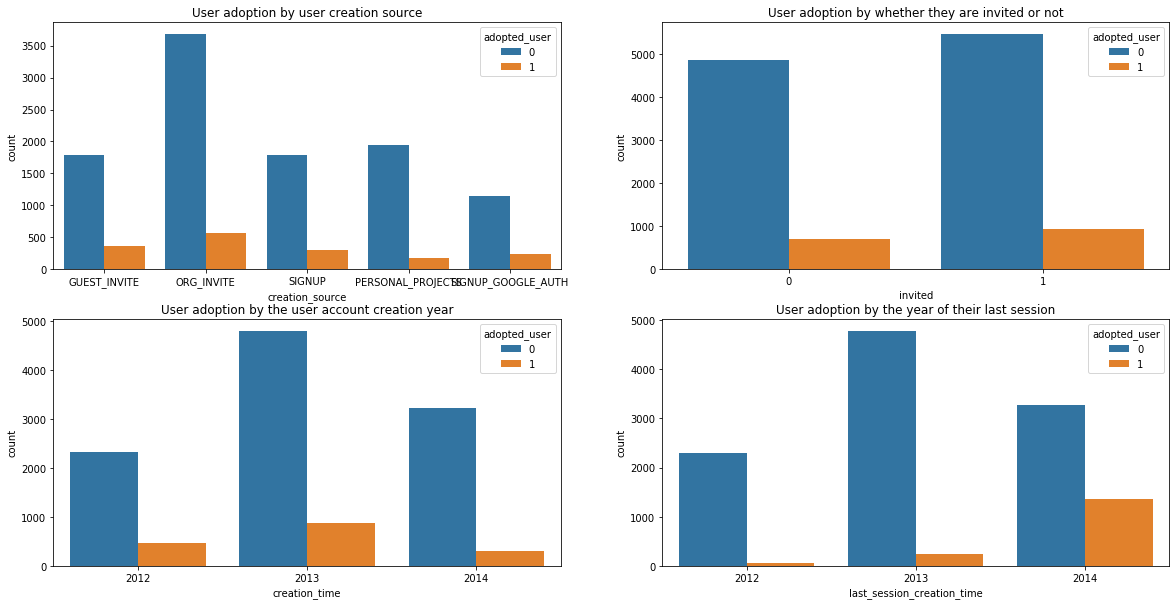

In [307]:
# look at categorical and datetime columns
plt.figure(figsize=(20,10));
ax1 = plt.subplot(2,2,1)
ax1 = sns.countplot(x='creation_source', hue='adopted_user', data=complete_df, ax=ax1)
ax1.set_title('User adoption by user creation source');

ax2 = plt.subplot(2,2,2)
ax2 = sns.countplot(x=complete_df.invited, hue=complete_df.adopted_user, ax=ax2)
ax2.set_title('User adoption by whether they are invited or not');

ax3 = plt.subplot(2,2,3)
ax3 = sns.countplot(x=complete_df.creation_time.dt.year, hue=complete_df.adopted_user, ax=ax3)
ax3.set_title('User adoption by the user account creation year');

ax4 = plt.subplot(2,2,4)
ax4 = sns.countplot(x=complete_df.last_session_creation_time.dt.year, hue=complete_df.adopted_user, ax=ax4)
ax4.set_title('User adoption by the year of their last session');

Since we have obtained meaningful features from 'creation_time' and 'last_session_creation_time', let's drop those features.

In [308]:
complete_df.drop(['creation_time','last_session_creation_time'], axis=1, inplace=True)

<b> Machine Learning Modeling</b>

Let's predict the user adoption rate using the random forest classifier. 

We need to convert all the categorical variables into numerical by transforming them using one-hot encoding method. Afterwards, the dataset must be split into 80% train and 20% test datasets. 

In [341]:
y=complete_df.adopted_user
y=y.astype('int')
X=complete_df.drop(['adopted_user'], axis=1)

In [342]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   creation_source             12000 non-null  object
 1   opted_in_to_mailing_list    12000 non-null  bool  
 2   enabled_for_marketing_drip  12000 non-null  bool  
 3   org_id                      12000 non-null  object
 4   invited                     12000 non-null  object
 5   history                     12000 non-null  int64 
 6   total_visits                12000 non-null  int64 
dtypes: bool(2), int64(2), object(3)
memory usage: 905.9+ KB


In [343]:
X = pd.get_dummies(X, drop_first=True)

In [344]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [345]:
#With default parameters
rfc = Pipeline([('scaler', StandardScaler()),('rfc', RandomForestClassifier())]) 
# set class_weight='balanced' to adjust for the imbalanced classes
rfc.fit(X_train, y_train)
pred_train = rfc.predict(X_train)
pred_test = rfc.predict(X_test)

# print feature importance
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': rfc.named_steps.rfc.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

/Users/varuni/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


                        feature  importance
2                       history    0.752356
3                  total_visits    0.138790
0      opted_in_to_mailing_list    0.004835
4    creation_source_ORG_INVITE    0.004538
1    enabled_for_marketing_drip    0.003855
..                          ...         ...
380                  org_id_373    0.000000
249                  org_id_242    0.000000
306                  org_id_299    0.000000
301                  org_id_294    0.000000
190                  org_id_183    0.000000

[425 rows x 2 columns]


In [346]:
#compute metrics

f1_train = f1_score(y_train, pred_train)
f1_test = f1_score(y_test, pred_test)
auc_train = roc_auc_score(y_train, pred_train)
auc_test = roc_auc_score(y_test, pred_test)

print(f1_train, auc_train)
print(f1_test, auc_test)

0.9939344925192074 0.9946376064352459
0.9341614906832297 0.9512060481746752


In [347]:
#With hyperparameter tuning
parameters = {'rfc__n_estimators': np.arange(20,90,5), 'rfc__max_features':['auto','sqrt','log2']}
# f1_score is used as the validation metric as it gives better sensitivity (wider range of score distribution) with imbalanced case
rfc_cv = GridSearchCV(rfc, parameters, scoring='f1', cv=5)
rfc_cv.fit(X_train, y_train)
print('Best parameters:', rfc_cv.best_params_)
print('Corresponding f1 score:', rfc_cv.best_score_)

Best parameters: {'rfc__max_features': 'sqrt', 'rfc__n_estimators': 65}
Corresponding f1 score: 0.947950796132463


In [348]:
#Using optimal parameters:
rfc = Pipeline([('scaler', StandardScaler()),('rfc', RandomForestClassifier(n_estimators=65, max_features='sqrt', class_weight='balanced'))])
rfc.fit(X_train, y_train)
pred_train = rfc.predict(X_train)
pred_test = rfc.predict(X_test)

# print feature importance
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': rfc.named_steps.rfc.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

                               feature    importance
3                         total_visits  5.121996e-01
2                              history  4.053931e-01
5    creation_source_PERSONAL_PROJECTS  6.372321e-03
0             opted_in_to_mailing_list  2.465426e-03
4           creation_source_ORG_INVITE  2.465373e-03
..                                 ...           ...
375                         org_id_368  1.636342e-10
391                         org_id_384  0.000000e+00
372                         org_id_365  0.000000e+00
417                         org_id_410  0.000000e+00
423                         org_id_416  0.000000e+00

[425 rows x 2 columns]


In [349]:
#compute metrics

f1_train = f1_score(y_train, pred_train)
f1_test = f1_score(y_test, pred_test)
auc_train = roc_auc_score(y_train, pred_train)
auc_test = roc_auc_score(y_test, pred_test)

print(f1_train, auc_train)
print(f1_test, auc_test)

1.0 1.0
0.9457177322074788 0.9689829292623603


From these results, it can be concluded that the top three features affecting user adoption is the total number of visits to the product, how much time has has elapsed between user account creation time and last session time (i.e. user account usage frequency), and the account creation course. The orgaization is seems to be the feature that affect user adoption the least.  